In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('liver.csv')

In [3]:
df["Albumin_and_Globulin_Ratio"] = df.Albumin_and_Globulin_Ratio.fillna(df['Albumin_and_Globulin_Ratio'].mean())

In [4]:
df = df[['Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio','Dataset']]

In [5]:
df.columns

Index(['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

<AxesSubplot:>

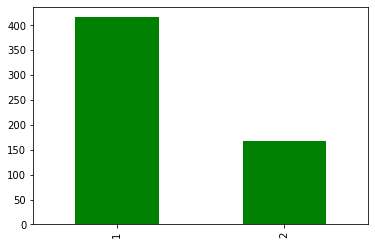

In [6]:
df['Dataset'].value_counts().plot(kind='bar',color='green')

In [7]:
y = df['Dataset']
X = df.drop('Dataset',axis=1)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(1)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

The number of classes before fit Counter({1: 416, 2: 167})
The number of classes after fit Counter({1: 416, 2: 416})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [9]:
X = X_ns
y = y_ns

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
xgb =RandomForestClassifier()

In [13]:
xgb.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(100,2000,2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [15]:
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 50, cv=cv, scoring='accuracy',error_score=0)

In [18]:
xgb_random.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, 102, 104, 106, 108,
                                                      110, 112, 114, 116, 118,
                                                      120, 122, 124, 126, 128,
                                                      130, 132, 134, 136, 138,
                                                      140, 142, 144, 146, 148,
                                                      150, 152, 154, 156, 158, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                      

In [19]:
best_model = xgb_random.best_estimator_

In [20]:
best_model

RandomForestClassifier(bootstrap=False, max_depth=1164, min_samples_split=5,
                       n_estimators=1558)

In [21]:
xgb_random.best_params_

{'n_estimators': 1558,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 1164,
 'bootstrap': False}

In [22]:
xgb_random.best_score_

0.8386031560490942

In [23]:
y_pred = best_model.predict(X_test)

In [24]:
err  =(y_pred- y_test)

<AxesSubplot:>

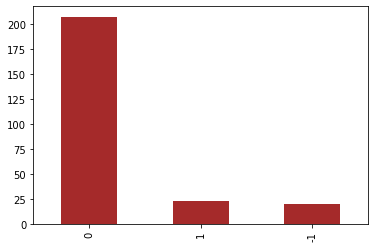

In [25]:
err.value_counts().plot(kind='bar',color='brown')

In [26]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.172
MSE: 0.172
RMSE: 0.4147288270665544


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 99  23]
 [ 20 108]]
              precision    recall  f1-score   support

           1       0.83      0.81      0.82       122
           2       0.82      0.84      0.83       128

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250



In [28]:
import pickle
# open a file, where you ant to store the data
file = open('random_forest_liver.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()